# Least squares examples
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

---------

In [1]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interactive
%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens

## 1. Fitting a line to data

Let's generate some noisy data that loosely follows a line:

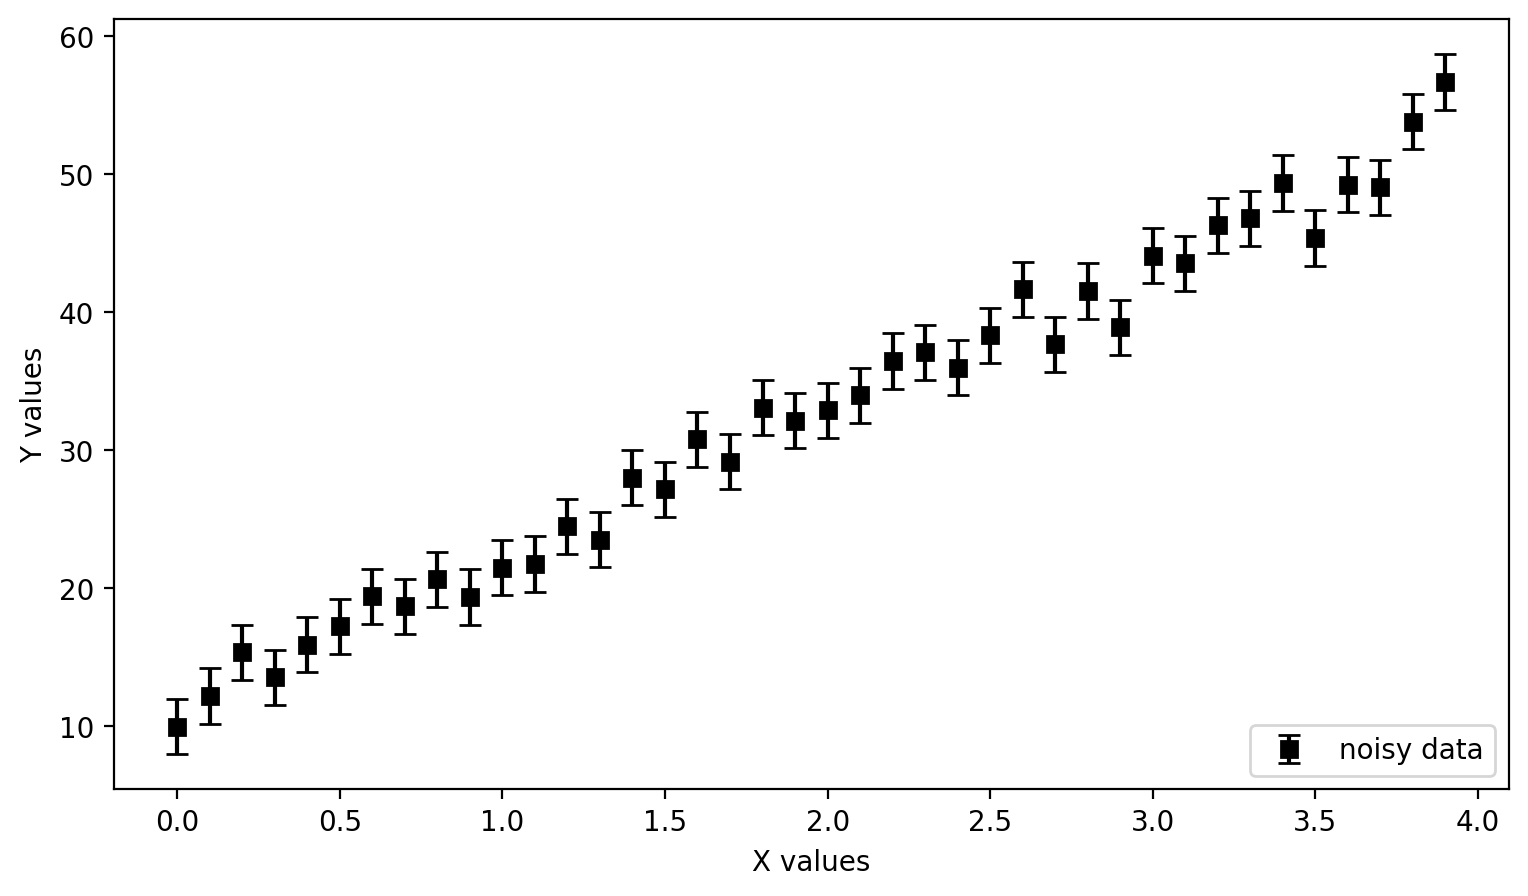

In [2]:
# create some noisy data
import numpy as np
import matplotlib.pyplot as plt

# first, create the time steps along the x axis: every 0.1 years for 4 years
x = np.arange(0,4,step=0.1)

# generate some noise with the same size as 'x'
noise_amplitude=2
noise = noise_amplitude * np.random.normal(size=np.shape(x))

# create a 'true' model with parameters a_true and b_true. These are the 'hidden' values we want to know
a_true = 5 + 10*np.random.rand()
b_true = 5 + 10*np.random.rand()

# create the y-values and add some noise.
# Question: how does the data look if you take out the noise?
y = a_true + b_true*x + noise

plt.figure(figsize=(9,5))
# note, since the data have noise, we should plot them with errorbars. Here is the command to do that:
plt.errorbar(x,y,yerr=noise_amplitude,fmt='ks',label='noisy data',capsize=4)
plt.legend(loc='lower right')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.show()

#### Activity: Try to fit the data by hand by guessing the values of a and b until the model looks good.

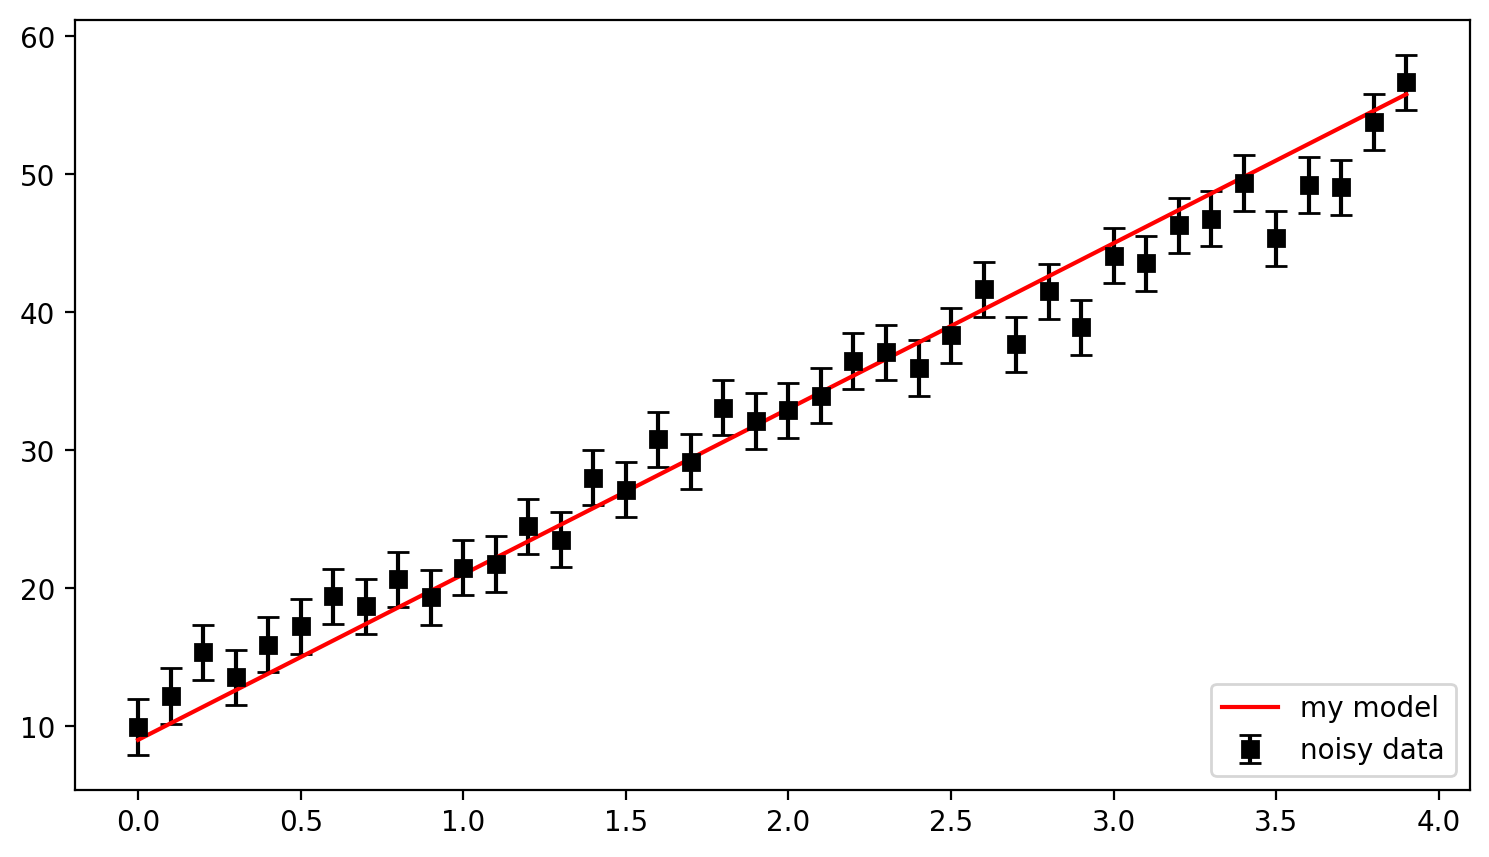

In [16]:
# Edit these values until the line looks good.
a=9
b=12

model = a + b*x

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=noise_amplitude,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,model,'-r',label='my model')
plt.legend(loc='lower right')
plt.show()

How close did you get? Run the cell below to find out.

Note, this command will print out the answer, so don't run it until you are satisfied with your estimate. Also, don't run the first cell above more than once, since the values of a and b will be different each time!

In [17]:
print("I estimated ", a, " for a, the true value was ", a_true)
print("I estimated ", b, " for b, the true value was ", b_true)

I estimated  9  for a, the true value was  11.159587632568922
I estimated  12  for b, the true value was  10.91803685899832


## 2. Fitting a model with linear algebra

For the model function $y = a + b x$, we can express this in matrix notation as follows:

    [y1] = [1  x1]  *  [a]
    [y2]   [1  x2]     [b]
    [y3]   [1  x3]
    [...]  [ ... ]  

Reading acros, the first row of this equation becomes $y_1 = a + bx_1$. The next row has $y_2$ and $x_2$, etc. The matrix on the left is an Nx1 column of the y-values, and on the right we have an Nx2 matrix filled with first a column of ones, and then a column of the x-values, multiplied into the 2x1 matrix with the parameters we want to fit - a and b. The result of multiplying a [Nx2] with [2x1] matrix is [Nx1], so we can see that the matrix dimensions work. 

In various fields, you may find the matrix [Nx2] matrix labeled as $A,$ $G,$ or $J$ and described as the "design matrix", "Greens functions" or the "Jacobian matrix". For any linear function $d(m)$, it can be calculated by taking the partial derivatives of the function $d$ with respect to each model parameter $m$. In the case above, where our function is $y = a + b x$, we find $\partial y/\partial a = 1$, and $\partial y/\partial b = x$, which become the columns of $G$. There is no secret magic to this, this is just the way to rewrite a set of linear equations as a matrix equation. If you don't like partial derivatives, you can also think of it as "factoring out" the parameters from the equation to put them in their own vector.

Using this method, we can express any model that is a linear function of the parameters as a matrix multiplication. In the field of geophysics this is typically written as $d=Gm$, where $G$ is our "design matrix" or "greens functions". In this case, it is filled with ones and x-values. In general, it contains all the problem-specific information, like geometry, observation points / station locations, etc. that does not relate to the particular measurement values or parameters themselves.

Using the theorems of linear algebra, we can show that the solution to the matrix problem $d=Gm$ can be written as $m=(G^TG)^{-1}G^Td$. This equation is complicated to look at, but in the computer we can work it out pretty quickly.


#### Step 1: create our 'design matrix'. For a linear model, this is a column of ones, next to a column of the x-coordinate of the data:

In [18]:
col1 = np.ones(np.shape(x))
col2 = x
# use np.column_stack to line up arrays as columns in a matrix. There is a similar function for rows, np.row_stack.
# note the double parentheses - we have to group all the columns together as a python "tuple" which is like a list but with round brackets.
G = np.column_stack((col1,col2))
print(G)

[[1.  0. ]
 [1.  0.1]
 [1.  0.2]
 [1.  0.3]
 [1.  0.4]
 [1.  0.5]
 [1.  0.6]
 [1.  0.7]
 [1.  0.8]
 [1.  0.9]
 [1.  1. ]
 [1.  1.1]
 [1.  1.2]
 [1.  1.3]
 [1.  1.4]
 [1.  1.5]
 [1.  1.6]
 [1.  1.7]
 [1.  1.8]
 [1.  1.9]
 [1.  2. ]
 [1.  2.1]
 [1.  2.2]
 [1.  2.3]
 [1.  2.4]
 [1.  2.5]
 [1.  2.6]
 [1.  2.7]
 [1.  2.8]
 [1.  2.9]
 [1.  3. ]
 [1.  3.1]
 [1.  3.2]
 [1.  3.3]
 [1.  3.4]
 [1.  3.5]
 [1.  3.6]
 [1.  3.7]
 [1.  3.8]
 [1.  3.9]]


#### Step 2: compute the best-fitting line using least squares

Recall our equation: 

$m=(G^TG)^{-1}G^Td$

We will use the numpy commands for transpose and inverse:

    np.transpose()
    np.linalg.inv()
    
And, to multiply matrices, use the .dot() method of numpy arrays, like so:

    A.dot(B)

Or, you can use np.matmul():

    np.matmul(A,B)

Note that if you literally write A * B for numpy arrays, it will try to multiply them element-wise, rather than doing matrix multiplication. Watch out!

Finally, remember that our "data" is the vector of observed values and is called "y" in this case.

In [19]:
# write out the equation m = (G^T * G)^-1 * G^T * d, using numpy:

m = np.linalg.inv(np.transpose(G).dot(G)).dot(np.transpose(G)).dot(y)


# print out the result, and compare to the true values from above.
print('The least squares answer is', m)
print('The true values were', a_true, b_true)

The least squares answer is [11.41512196 10.71285855]
The true values were 11.159587632568922 10.91803685899832


Note, these values should be pretty close to our true values but not exactly equal - this is because we added noise! In general, the presence of noise means we will never be able to exactly measure the **true model** values. 

If you like, try running it again without noise - you should find that the estimated and true values are equal. (If they are not exactly equal, this may come from floating-point errors accumulated during the matrix inversion step. In the field of Computer Science, lots of effort has gone into designing ways of reducing this floating-point error in the computer.)

Now, let's plot the model on top of the data and see how it fits. Remember, we can get our "predicted" data (y-values of the model) with the equation $d = G * m$

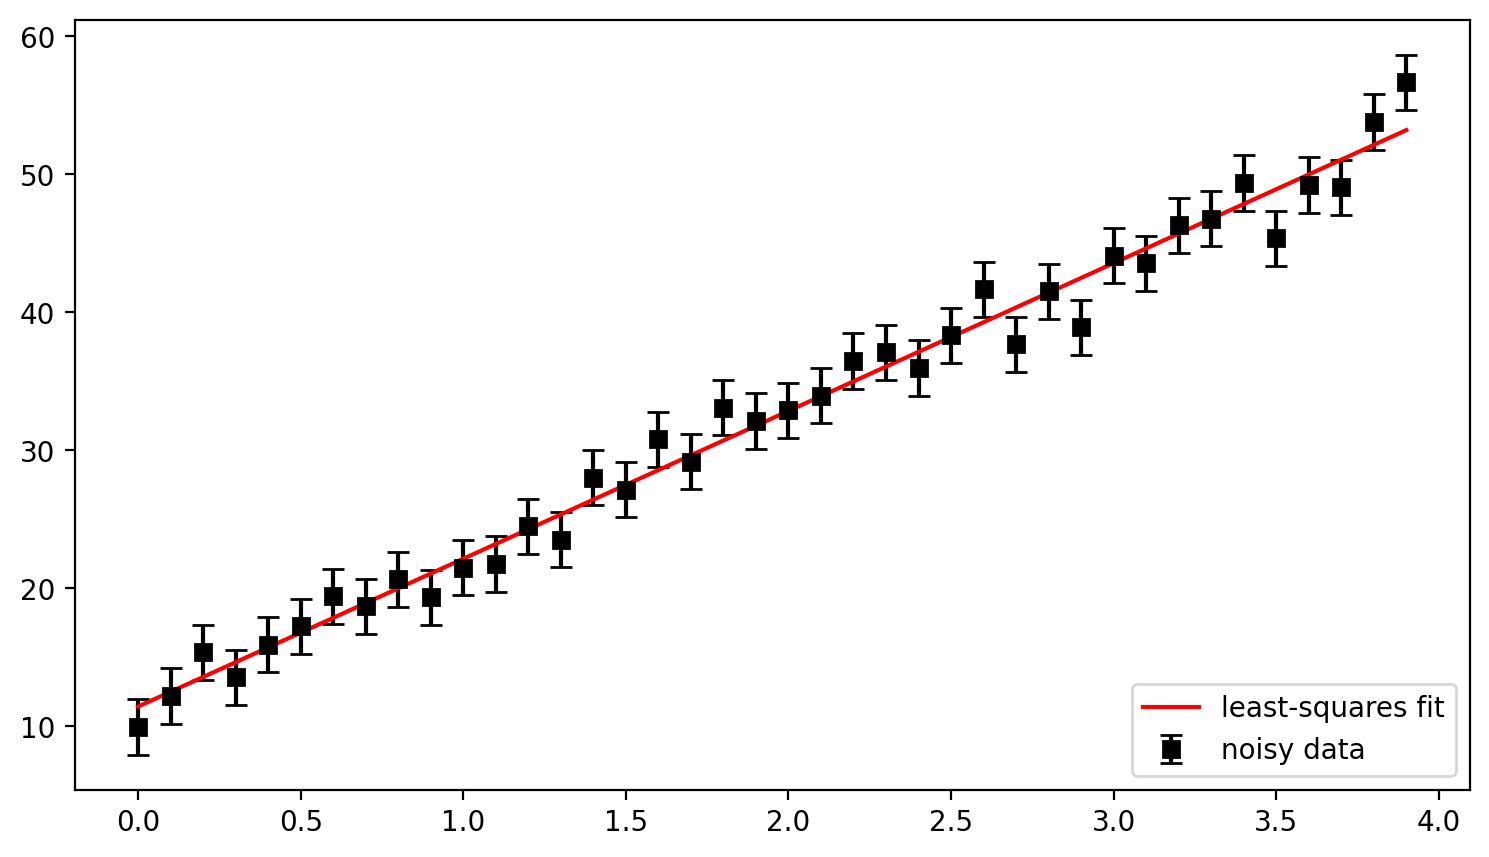

In [20]:
# data_predicted is just G*m, with the m values we determined above.
data_predicted = G.dot(m)

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=noise_amplitude,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,data_predicted, '-r', label='least-squares fit')
plt.legend(loc='lower right')

## 3. Fitting the data with python automatically

Since least-squares fitting is such a common activity, there are nice, easy functions in python to do it. Let's use one called scipy.optimize.curve_fit.

For this method, we must define our linear model as a function, whose name we pass to curve_fit along with the observation vector x, the data y, and an initial estimate of the model parameters (called "p0" by scipy).

In [21]:
import scipy.optimize

Linear algebra found: [11.41512196 10.71285855]
Scipy curve_fit found: [11.41512197 10.71285855]
The true values were:  [11.15958763 10.91803686]


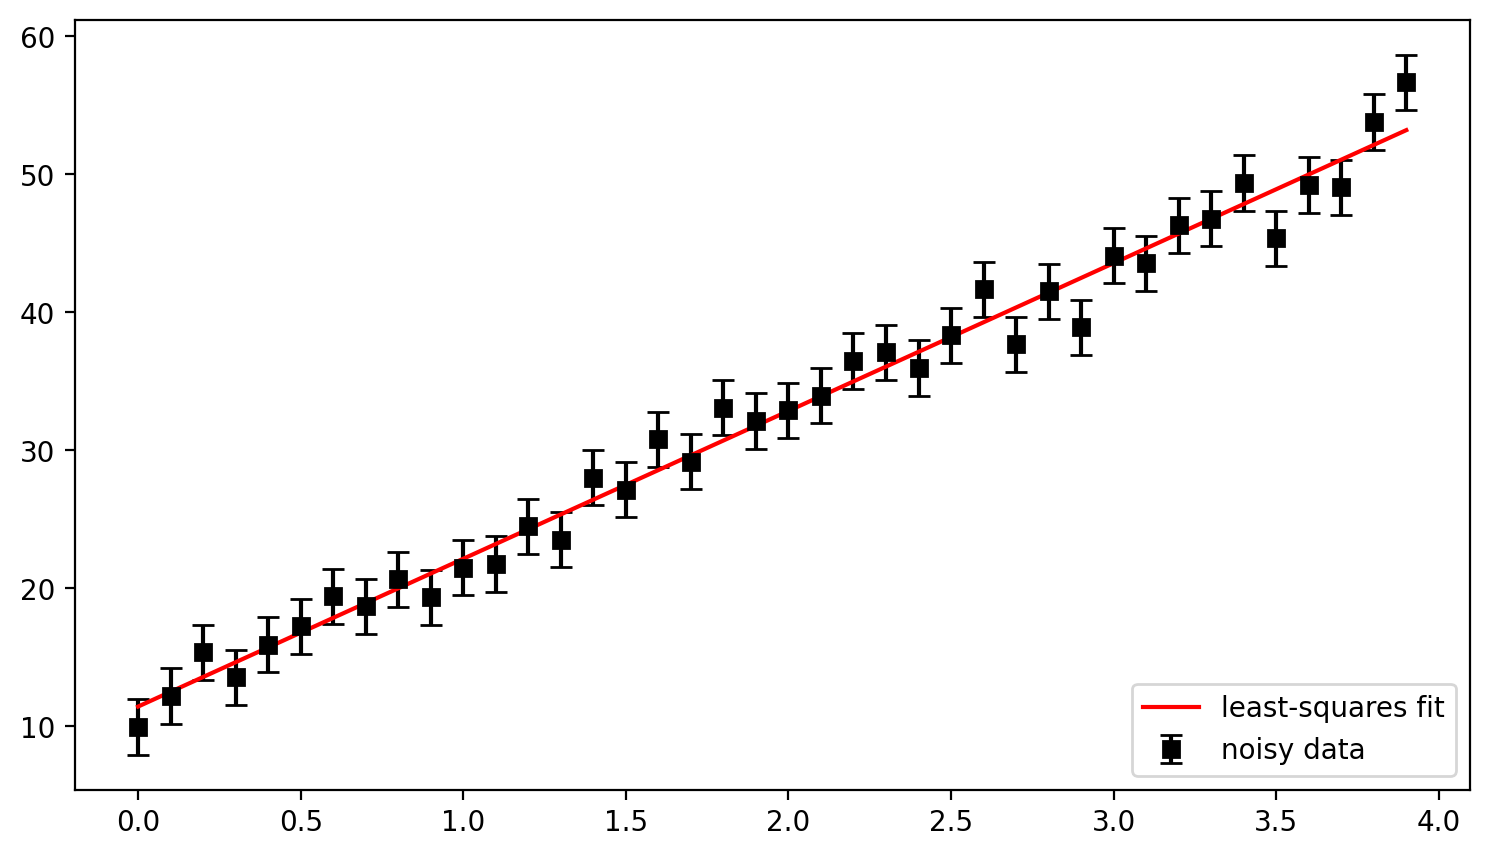

In [22]:
def my_line(x,a,b):
    return a + b*x

# here, p0 is the 'initial guess' for this method. 
# m is the model output, and mcov is the model covariance, or uncertainties.
m2,mcov = scipy.optimize.curve_fit(my_line,x,y,p0=[0,0])
print('Linear algebra found:',m)
print('Scipy curve_fit found:',m2)
print('The true values were:  [%.8f %.8f]'%(a_true,b_true))

# to get the predicted y-values, we can just call our function my_line with the 
# model parameters determined by scipy.

# Note: we introduce a special python concept here called "unpacking" a list - when we write *m,
# this sends each of the elements of the list 'm' as separate arguments to the function.
y_predicted = my_line(x,*m2) 
# so the above line is equivalent to:
# y_predicted = my_line(x,m[0],m[1])

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=noise_amplitude,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,y_predicted, '-r', label='least-squares fit')
plt.legend(loc='lower right')
plt.show()

### Example: Fit some data that is not linear! 

We create some synthetic data that has a slope, interecept and also has a step function, which we can model using the numpy function np.heaviside(). Can you modify the scipy function to fit all 3 parameters?

In [23]:
# define some 'true' model parameter values
a_true = 10*np.random.rand()
b_true = 2*np.random.rand()
c_true = 30*np.random.rand()
d_true = 2*np.random.rand()

Scipy curve_fit estimated [8.89124919 1.99987693 0.12062433 2.03809791]
The true values were      [6.37876919 1.99684554 2.66629943 0.12752823]


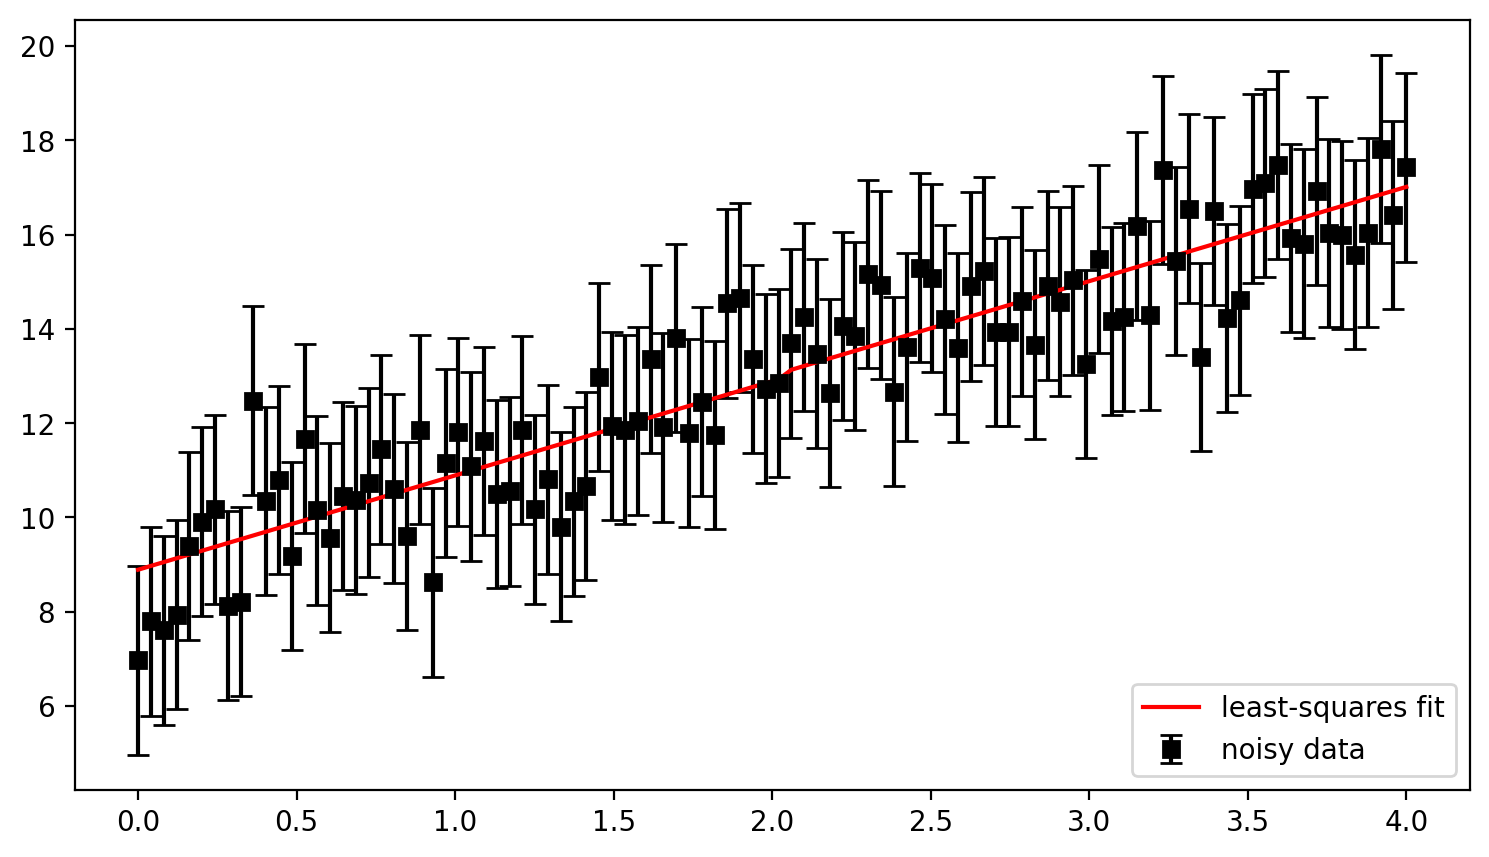

In [103]:
# we use the error function (erf) to create a step function that is slightly smooth, so scipy can optimize it. 
# We should use the heaviside function instead, but it is not differentiable, which causes the curve_fit method to not work well...
from scipy.special import erf

def my_smooth_function(x, a, b, c, d):
    return a + b*x + c * 0.5 * (1 + erf(200 * (x - d)))

# define our independent variable - the "x" locations of the data points
x=np.linspace(0,4,100)


y_nonoise=my_smooth_function(x,a_true,b_true,c_true,d_true)
y = y_nonoise + np.random.normal(size=np.shape(x))


# use scipy.optimize.curve_fit here to fit the model with 3 parameters
m3,mcov = scipy.optimize.curve_fit(my_smooth_function,x,y,p0=[-1.89,-1.875,0.00019,2])
# get the predicted y-values
y_predicted = my_smooth_function(x,*m3) 

print('Scipy curve_fit estimated', m3)
print('The true values were      [%.8f %.8f %.8f %.8f]'%(a_true,b_true,c_true,d_true))

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=noise_amplitude,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,y_predicted, '-r', label='least-squares fit')
plt.legend(loc='lower right')
plt.show()

Note: in the code above, the step function time (parameter "d") is not always accurately estimated! This turns out to be a generally difficult thing to do, since this is a very non-linear parameter. In my experimentation, I found that a good way to improve the results is to provide a visual estimate of the time of the offset in our "p0" parameter; this usually gives scipy a good start. On the flip side, a very bad guess will usually lead to bad results.